<a href="https://colab.research.google.com/github/anuritabose/Sarcasm-Detection-using-Tensorflow-Keras---ML_Approach/blob/master/Sarcasm_Detection_using_Bidirectional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
vocab_size = 17500
embedding_dim = 50
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 90768

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Dataset5_reshuffled (3).json to Dataset5_reshuffled (3).json


In [ ]:
with open("Dataset5_reshuffled (3).json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['sentence'])
    labels.append(item['label'])

In [ ]:
for i in range(len(sentences)):
  sentences[i]=str(sentences[i]).lower()

In [ ]:
import string
from string import digits, punctuation

sentences_cleansed = []
for s in sentences:
  #print(s)
#     Remove punctuations
  clean = str(s).translate(str.maketrans('', '', punctuation))
#     Remove digits/numbers
  clean = clean.translate(str.maketrans('', '', digits))
  sentences_cleansed.append(clean)
    

In [ ]:
training_sentences = sentences_cleansed[0:training_size]
testing_sentences = sentences_cleansed[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [ ]:
!pip install emoji

     |████████████████████████████████| 51kB 1.8MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=d88bc4ce04bfb5db18930ac10040fcac66f70b70b5d8ee3754b1226b1dabebc2
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [ ]:
import emoji
from emoji import UNICODE_EMOJI

# search your emoji
def is_emoji(s):
    return s in UNICODE_EMOJI

# add space near your emoji
def add_space(text):
    return ''.join(' ' + char + ' ' if is_emoji(char) else char for char in text).strip()

spacedEmoji_training_sentences=[]
spacedEmoji_testing_sentences=[]

for i in training_sentences:
  i=add_space(i)
  spacedEmoji_training_sentences.append(i)

for i in testing_sentences:
  i=add_space(i)
  spacedEmoji_testing_sentences.append(i)



In [ ]:
# Tokenization process
training_tokens = []
for s in spacedEmoji_training_sentences:
    training_tokens.append(s.split())

# View Comparison
index = 100
print('Before tokenization :')
print(spacedEmoji_training_sentences[index])
print('\nAfter tokenization :')
print(training_tokens[index])

Before tokenization :
just waiting for noon so i can go to the mall and buy some weights and ankle socks

After tokenization :
['just', 'waiting', 'for', 'noon', 'so', 'i', 'can', 'go', 'to', 'the', 'mall', 'and', 'buy', 'some', 'weights', 'and', 'ankle', 'socks']


In [ ]:
# Tokenization process
testing_tokens = []
for s in spacedEmoji_testing_sentences:
    testing_tokens.append(s.split())

# View Comparison
index = 100
print('Before tokenization :')
print(spacedEmoji_testing_sentences[index])
print('\nAfter tokenization :')
print(testing_tokens[index])

Before tokenization :
if you dont even follow me and i dont follow you why would i recommend someone else to follow you

After tokenization :
['if', 'you', 'dont', 'even', 'follow', 'me', 'and', 'i', 'dont', 'follow', 'you', 'why', 'would', 'i', 'recommend', 'someone', 'else', 'to', 'follow', 'you']


In [ ]:
!pip install nltk

In [ ]:
# Lemmatize with appropriate POS Tag
# Credit : www.machinelearningplus.com/nlp/lemmatization-examples-python/

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Init Lemmatizer
lemmatizer = WordNetLemmatizer()

training_lemmatized = []
testing_lemmatized=[]

for tokens in training_tokens:
    lemm = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    training_lemmatized.append(lemm)

for tokens in testing_tokens:
    lemm = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    testing_lemmatized.append(lemm)

'''
# Example comparison
word_1 = ['skyrim','dragons', 'are', 'having', 'parties']
word_2 = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_1]
print('Before lemmatization :\t',word_1)
print('After lemmatization :\t',word_2)

#print(sentences_lemmatized[:10])'''

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


"\n# Example comparison\nword_1 = ['skyrim','dragons', 'are', 'having', 'parties']\nword_2 = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_1]\nprint('Before lemmatization :\t',word_1)\nprint('After lemmatization :\t',word_2)\n\n#print(sentences_lemmatized[:10])"

In [ ]:
# Vectorize and convert text into sequences
#max_features = 2000
if len(max(training_lemmatized)) > len(max(testing_lemmatized)):
  max_token= len(max(training_lemmatized)) 
else:
  max_token= len(max(testing_lemmatized))

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_lemmatized)

training_sequences = tokenizer.texts_to_sequences(training_lemmatized)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_lemmatized)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

#print(testing_padded,testing_labels)

In [ ]:
index=100
print('Before :')
print(testing_lemmatized[index],'\n')
print('After sequences convertion :')
print(testing_sequences[index],'\n')
print('After padding :')
print(testing_padded[index])


Before :
['if', 'you', 'dont', 'even', 'follow', 'me', 'and', 'i', 'dont', 'follow', 'you', 'why', 'would', 'i', 'recommend', 'someone', 'else', 'to', 'follow', 'you'] 

After sequences convertion :
[39, 7, 36, 104, 207, 16, 8, 3, 36, 207, 7, 80, 93, 3, 2636, 108, 377, 5, 207, 7] 

After padding :
[  39    7   36  104  207   16    8    3   36  207    7   80   93    3
 2636  108  377    5  207    7    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [ ]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Using TensorFlow backend.


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, activation='relu' )),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)
model.compile(loss='binary_crossentropy', optimizer=opt , metrics=['accuracy', f1_m, precision_m, recall_m])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           875000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               58880     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 934,009
Trainable params: 934,009
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 70

#validation_data=(testing_padded, testing_labels)
#print(type(training_padded),type(training_labels),type(num_epochs),type(testing_labels),type(validation_data))
#print(training_padded,training_labels,num_epochs,testing_padded,testing_labels)
history = model.fit(training_padded, training_labels, batch_size=128, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/70
710/710 - 323s - loss: 21.5825 - accuracy: 0.5884 - f1_m: 0.6016 - precision_m: 0.5887 - recall_m: 0.6600 - val_loss: 0.6772 - val_accuracy: 0.6663 - val_f1_m: 0.6465 - val_precision_m: 0.6812 - val_recall_m: 0.6185
Epoch 2/70
710/710 - 323s - loss: 0.6740 - accuracy: 0.6740 - f1_m: 0.6807 - precision_m: 0.6676 - recall_m: 0.7004 - val_loss: 0.6716 - val_accuracy: 0.6852 - val_f1_m: 0.6812 - val_precision_m: 0.6846 - val_recall_m: 0.6811
Epoch 3/70
710/710 - 324s - loss: 0.6674 - accuracy: 0.6918 - f1_m: 0.6926 - precision_m: 0.6933 - recall_m: 0.7000 - val_loss: 0.6660 - val_accuracy: 0.6921 - val_f1_m: 0.6838 - val_precision_m: 0.6963 - val_recall_m: 0.6750
Epoch 4/70
710/710 - 326s - loss: 0.6608 - accuracy: 0.7033 - f1_m: 0.6930 - precision_m: 0.7187 - recall_m: 0.6751 - val_loss: 0.6605 - val_accuracy: 0.6960 - val_f1_m: 0.7059 - val_precision_m: 0.6788 - val_recall_m: 0.7387
Epoch 5/70
710/710 - 321s - loss: 14.9979 - accuracy: 0.7071 - f1_m: 0.7186 - precision_m: 0.69

In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(testing_padded, testing_labels, verbose=0)
print(loss)
print(accuracy)
print(f1_score)
print(precision)
print(recall)

0.5561439990997314
0.7455931901931763
0.7289113998413086
0.7637484073638916
0.7091068029403687


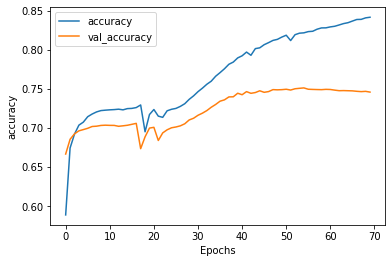

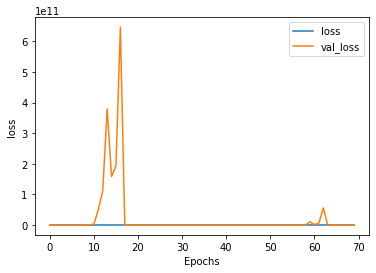

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(17500, 50)


In [ ]:
sentence = ["i love you🙄","i love you!",
            "losing is the best",
            "thank you! you are my favourite ",
            "i love being poor🙄",
            "sun is  a star ",
            "thank god for mondays!","thank god for mondays #sarcasm"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred=(model.predict(padded))
i=0

print(pred)
#print(type(pred))

[[0.85739744]
 [0.8348608 ]
 [0.5247235 ]
 [0.70229137]
 [0.6563212 ]
 [0.71824247]
 [0.5874607 ]
 [0.99328125]]


In [ ]:
import numpy as np
count_correct=0
count_wrong=0

sequences = tokenizer.texts_to_sequences(testing_sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred=(model.predict(padded))
i=0
for x in np.nditer(pred):
  #print(x, "\t", testing_labels[i])
  if (testing_labels[i]==1 and x>=0.5) or (testing_labels[i]==0 and x<0.5) :
    count_correct+=1
  else:
    count_wrong+=1
  i+=1

print(count_correct)
print(count_wrong)
#print(type(pred))

16478
6214


In [ ]:
results = model.evaluate(testing_padded, testing_labels, batch_size=128)
print("test loss, test acc:", results)

178/178 [==============================] - 11s 61ms/step - loss: 0.5561 - accuracy: 0.7456 - f1_m: 0.7332 - precision_m: 0.7636 - recall_m: 0.7085
test loss, test acc: [0.5561438202857971, 0.7455931901931763, 0.733207643032074, 0.7635896801948547, 0.7084838151931763]
